# Supervised Machine Learning Model

In this chapter we are presenting logistic regression and support vector machine models to see to what degree we can associate given tweet with it being posted by a party from opposition or proposition.

## 1. Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
import torch
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score

## 2. Reading data

In [2]:
df_filtered = pd.read_parquet('cleaned_data\df_combined.parquet')
df_filtered['opposition_proposition'] = df_filtered['party'].apply(lambda x: 1 if x in ['Konfederacja', 'PIS'] else 0)
df_filtered = df_filtered[df_filtered['text_clean_en'].notna()]

X = df_filtered['text_clean_en']
y = df_filtered['opposition_proposition']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Creating word embeddings

In [3]:
# TF-IDF
print("TF-IDF")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Sentence Transformers
print("SentenceTransformer")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df_filtered['encode_transforemers'] = df_filtered['text_clean_en_demojized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())
X_train_st = np.array(df_filtered.loc[X_train.index, 'encode_transforemers'].tolist())
X_test_st = np.array(df_filtered.loc[X_test.index, 'encode_transforemers'].tolist())

# CLS_BERT 
print("CLS_BERT")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_cls_sentence(sentence):
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    return cls_embedding.flatten()

df_filtered['cls_bert'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: get_cls_sentence(sentence))
X_train_cls_bert = np.array(df_filtered.loc[X_train.index, 'cls_bert'].tolist())
X_test_cls_bert = np.array(df_filtered.loc[X_test.index, 'cls_bert'].tolist())


TF-IDF
SentenceTransformer


C:\Users\CarpeDiem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


CLS_BERT


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


## 4. Logistic regression model
Below, there are logistic regression models basing on the word embeddings

Classification Report for TF-IDF:
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       877
           1       0.77      0.89      0.83      1374

    accuracy                           0.77      2251
   macro avg       0.78      0.74      0.75      2251
weighted avg       0.77      0.77      0.77      2251

AUC for TF-IDF: 0.86


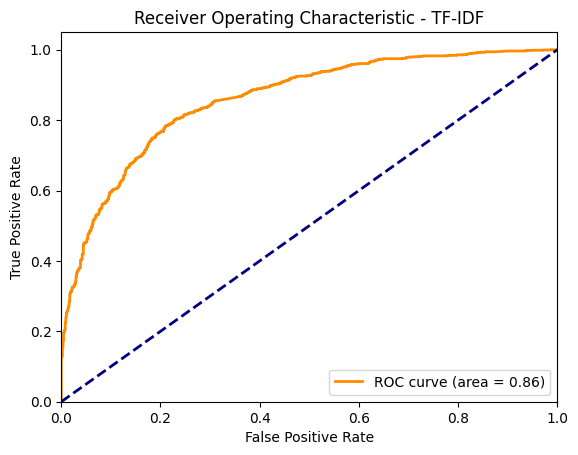

Classification Report for Sentence Transformers:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       877
           1       0.78      0.84      0.81      1374

    accuracy                           0.76      2251
   macro avg       0.75      0.73      0.74      2251
weighted avg       0.75      0.76      0.75      2251

AUC for Sentence Transformers: 0.82


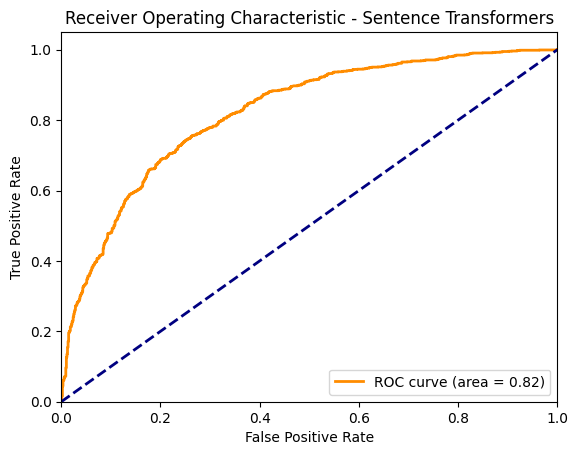

Classification Report for CLS_BERT:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       877
           1       0.79      0.85      0.82      1374

    accuracy                           0.77      2251
   macro avg       0.76      0.75      0.75      2251
weighted avg       0.77      0.77      0.77      2251

AUC for CLS_BERT: 0.83


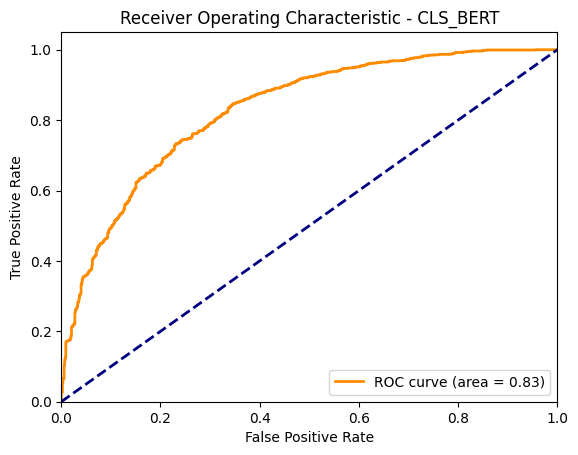

In [4]:
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def train_evaluate_and_plot(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"AUC for {model_name}: {roc_auc_score(y_test, y_pred_proba):.2f}")
    plot_roc_curve(y_test, y_pred_proba, model_name)

# TF-IDF
train_evaluate_and_plot(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

# Sentence Transformers
train_evaluate_and_plot(X_train_st, X_test_st, y_train, y_test, "Sentence Transformers")

# CLS_BERT
train_evaluate_and_plot(X_train_cls_bert, X_test_cls_bert, y_train, y_test, "CLS_BERT")

We can observe that the performance of Logistic Regression does not vary significantly across different embedding methods. While the best performance was achieved using the TF-IDF embedding method, it is worth noting that its advantage over the other methods is minimal.

## 5. Support vector machines models

Below, there are 3 support vector machine models based on the word embeddings from chapter 5. Models have been tuned and cross-validated. 

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=  36.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=  30.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=  25.2s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  31.8s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  32.1s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  31.6s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  26.2s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  25.3s
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time=  29.2s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  45.6s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  37.7s
[CV] END ........................C=1, gamma=0.01,

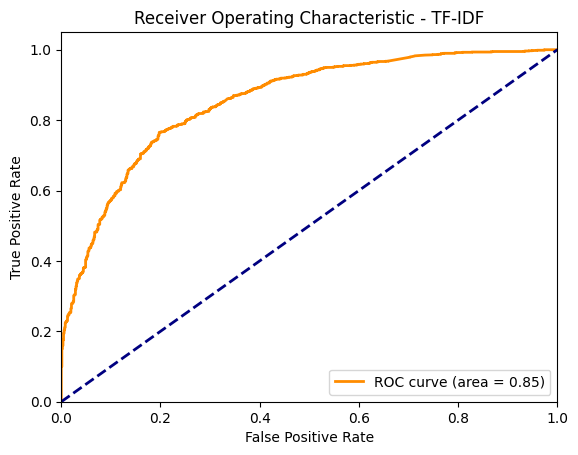

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 1.1min
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 1.1min
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 1.1min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.4min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.4min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.4min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.1min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.1min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 1.1min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 1.0min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 1.0min
[CV] END ........................C=1, gamma=0.01,

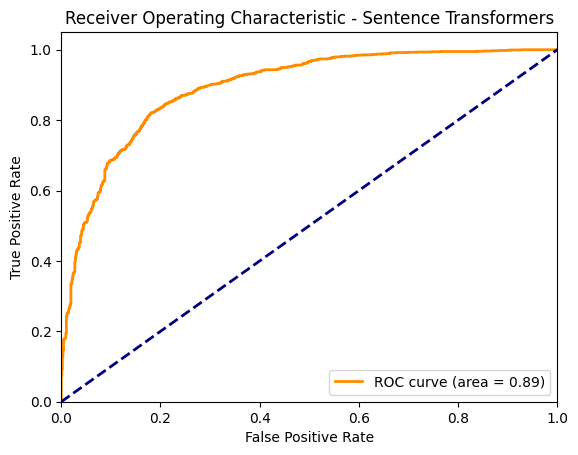

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 2.5min
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 1.8min
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time= 1.8min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 2.4min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 2.4min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 5.5min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 3.0min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 3.4min
[CV] END .....................C=1, gamma=0.01, kernel=linear; total time= 3.6min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 3.3min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 2.7min
[CV] END ........................C=1, gamma=0.01,

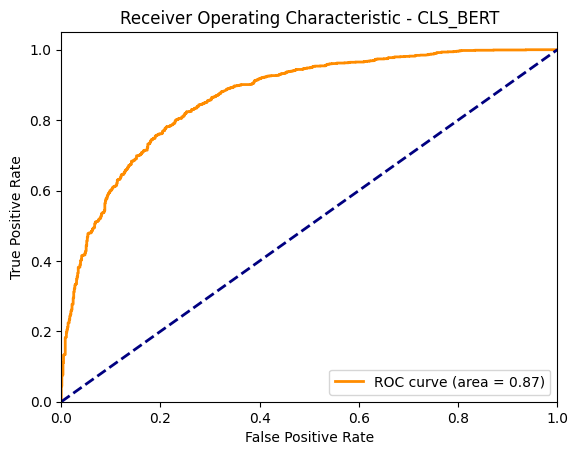

In [5]:

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [1, 10],
    'gamma': [0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Perform hyperparameter tuning using GridSearchCV
def tune_and_evaluate_svm(X_train, y_train, model_name):
    grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=3)
    grid.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    best_model = grid.best_estimator_
    return best_model

# Train and evaluate SVM models with cross-validation
def train_evaluate_and_plot_svm(X_train, X_test, y_train, y_test, model_name):
    best_model = tune_and_evaluate_svm(X_train, y_train, model_name)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = best_model.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"AUC for {model_name}: {roc_auc_score(y_test, y_pred_proba):.2f}")
    plot_roc_curve(y_test, y_pred_proba, model_name)

# TF-IDF
train_evaluate_and_plot_svm(X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

# Sentence Transformers
train_evaluate_and_plot_svm(X_train_st, X_test_st, y_train, y_test, "Sentence Transformers")

# CLS_BERT
train_evaluate_and_plot_svm(X_train_cls_bert, X_test_cls_bert, y_train, y_test, "CLS_BERT")

We observe that SVM outperforms Logistic Regression, particularly in effectively capturing the minority opposition class, which has fewer samples than the preposition class. This capability contributes to its overall better performance, achieving an F1-score of 0.81 and an AUC of 0.85.

## 6. Conclusions 

1. Logistic Regression shows consistent performance across different embedding methods, with minimal variation. The TF-IDF embedding method achieved the best performance. However, its advantage in performance over the other methods is negligible. The main advantage of TF-IDF is the time required to generate embeddings, which is almost immediate compared to the other methods.

2. SVM demonstrates better performance compared to Logistic Regression, particularly in handling the minority opposition class, which has fewer samples than the proposition class. This capability contributes to its overall better performance, achieving an F1-score of 0.81 and an AUC of 0.89.